In [2]:
import os, math, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras_hub.models import ViTImageClassifier

from sklearn.metrics import classification_report, confusion_matrix
import itertools

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
DATA_ROOT = "./processed"
RESULTS_DIR = "./results_vit"
os.makedirs(RESULTS_DIR, exist_ok=True)

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
VAL_SPLIT = 0.20
TEST_SPLIT_FROM_VAL = 0.5

AUTOTUNE = tf.data.AUTOTUNE

## Load Data & Split Data

In [5]:
# Load train+val from directory
full_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT,
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    subset="both",
    seed=42,
)

train_ds, val_ds_raw = full_ds
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)
print("Number of classes:", NUM_CLASSES)

Found 42385 files belonging to 13 classes.
Using 33908 files for training.
Using 8477 files for validation.
Classes: ['Academic_Art', 'Art_Nouveau', 'Baroque', 'Expressionism', 'Japanese_Art', 'Neoclassicism', 'Primitivism', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Western_Medieval']
Number of classes: 13


In [6]:
# Split val into val + test
val_batches = tf.data.experimental.cardinality(val_ds_raw)
test_ds = val_ds_raw.take(val_batches // 2)
val_ds  = val_ds_raw.skip(val_batches // 2)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

Train batches: 1060
Val batches: 133
Test batches: 132


In [11]:
# Data augmentation (used inside the ViT model)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.05)
    ],
    name="data_augmentation"
)

def prepare_dataset(ds, shuffle=False, augment=False):
    def apply_augment(x, y):
        x = tf.cast(x, tf.float32) / 255.0
        if augment:
            x = data_augmentation(x)
        return x, y
    ds = ds.map(apply_augment, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    return ds.prefetch(AUTOTUNE)

train_ds_prep = prepare_dataset(train_ds, shuffle=True, augment=True)
val_ds_prep   = prepare_dataset(val_ds, shuffle=False, augment=False)
test_ds_prep  = prepare_dataset(test_ds, shuffle=False, augment=False)

## Build Vision Transformer Model

In [13]:
# Callbacks
checkpoint_path = os.path.join(RESULTS_DIR, "vit_best.keras")
callbacks = [
    keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
    ),
]

In [16]:
vit_pre_model = ViTImageClassifier.from_preset(
    "vit_base_patch16_224_imagenet",
    num_classes=NUM_CLASSES,
    preprocessor=None,
)

vit_pre_model.backbone.trainable = False

vit_pre_model.compile(
    optimizer=keras.optimizers.Adam(5e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

vit_pre_model.summary()

Model: "vi_t_image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                       ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)                           │ (None, 224, 224, 3)                │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ vi_t_backbone (ViTBackbone)                   │ (None, 197, 768)                   │          85,798,656 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ get_item (GetItem)                            │ (None, 768)                        │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ output_dropout (Dropout)                      │ (None, 768)                        │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ predictions (Dense)                           │ (None, 13)                         │               9,997 │
└───────────────────────────────────────────────┴────────────────────────────────────┴─────────────────────┘

 Total params: 85,808,653 (327.33 MB)

 Trainable params: 9,997 (39.05 KB)

 Non-trainable params: 85,798,656 (327.30 MB)

In [18]:
history_vit_pre = vit_pre_model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/15


2025-12-07 14:09:54.395455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 744 of 1000
2025-12-07 14:09:57.862226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3648s 3s/step - accuracy: 0.2493 - loss: 2.3505 - val_accuracy: 0.3289 - val_loss: 2.0593 - learning_rate: 5.0000e-05
Epoch 2/15


2025-12-07 15:10:40.115774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 619 of 1000
2025-12-07 15:10:46.171693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3580s 3s/step - accuracy: 0.3777 - loss: 1.8889 - val_accuracy: 0.4037 - val_loss: 1.8102 - learning_rate: 5.0000e-05
Epoch 3/15


2025-12-07 16:10:19.865490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 633 of 1000
2025-12-07 16:10:25.908094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3616s 3s/step - accuracy: 0.4346 - loss: 1.7057 - val_accuracy: 0.4472 - val_loss: 1.6665 - learning_rate: 5.0000e-05
Epoch 4/15


2025-12-07 17:10:36.261712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 639 of 1000
2025-12-07 17:10:42.134394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3572s 3s/step - accuracy: 0.4696 - loss: 1.5990 - val_accuracy: 0.4721 - val_loss: 1.5806 - learning_rate: 5.0000e-05
Epoch 5/15


2025-12-07 18:10:07.961265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 647 of 1000
2025-12-07 18:10:13.866141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3572s 3s/step - accuracy: 0.4973 - loss: 1.5215 - val_accuracy: 0.4928 - val_loss: 1.5205 - learning_rate: 5.0000e-05
Epoch 6/15


2025-12-07 19:09:40.411627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 650 of 1000
2025-12-07 19:09:46.380210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3587s 3s/step - accuracy: 0.5139 - loss: 1.4669 - val_accuracy: 0.5095 - val_loss: 1.4677 - learning_rate: 5.0000e-05
Epoch 7/15


2025-12-07 20:09:27.829052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 607 of 1000
2025-12-07 20:09:34.581312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3713s 3s/step - accuracy: 0.5336 - loss: 1.4170 - val_accuracy: 0.5208 - val_loss: 1.4309 - learning_rate: 5.0000e-05
Epoch 8/15


2025-12-07 21:11:21.043620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 524 of 1000
2025-12-07 21:11:30.008428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3734s 4s/step - accuracy: 0.5425 - loss: 1.3815 - val_accuracy: 0.5276 - val_loss: 1.4021 - learning_rate: 5.0000e-05
Epoch 9/15


2025-12-07 22:13:34.956547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 595 of 1000
2025-12-07 22:13:42.171198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3616s 3s/step - accuracy: 0.5523 - loss: 1.3529 - val_accuracy: 0.5396 - val_loss: 1.3748 - learning_rate: 5.0000e-05
Epoch 10/15


2025-12-07 23:13:50.451392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 644 of 1000
2025-12-07 23:13:56.317150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3582s 3s/step - accuracy: 0.5617 - loss: 1.3259 - val_accuracy: 0.5467 - val_loss: 1.3612 - learning_rate: 5.0000e-05
Epoch 11/15


2025-12-08 00:13:32.526973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 647 of 1000
2025-12-08 00:13:38.081298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3574s 3s/step - accuracy: 0.5701 - loss: 1.3068 - val_accuracy: 0.5523 - val_loss: 1.3380 - learning_rate: 5.0000e-05
Epoch 12/15


2025-12-08 01:13:06.893832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 624 of 1000
2025-12-08 01:13:13.087956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3588s 3s/step - accuracy: 0.5742 - loss: 1.2887 - val_accuracy: 0.5584 - val_loss: 1.3219 - learning_rate: 5.0000e-05
Epoch 13/15


2025-12-08 02:12:55.022208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 632 of 1000
2025-12-08 02:13:00.985457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3536s 3s/step - accuracy: 0.5799 - loss: 1.2684 - val_accuracy: 0.5601 - val_loss: 1.3110 - learning_rate: 5.0000e-05
Epoch 14/15


2025-12-08 03:11:51.269204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 625 of 1000
2025-12-08 03:11:57.594969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3569s 3s/step - accuracy: 0.5848 - loss: 1.2524 - val_accuracy: 0.5624 - val_loss: 1.3015 - learning_rate: 5.0000e-05
Epoch 15/15


2025-12-08 04:11:19.948416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 633 of 1000
2025-12-08 04:11:26.264998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3558s 3s/step - accuracy: 0.5915 - loss: 1.2411 - val_accuracy: 0.5660 - val_loss: 1.2871 - learning_rate: 5.0000e-05


In [21]:
SAVE_DIR = "./models"
os.makedirs(SAVE_DIR, exist_ok=True)
SAVED_MODEL_DIR = './models/art_style_vit.keras'

vit_pre_model.save(SAVED_MODEL_DIR)

print(f"Model saved successfully to directory: {os.path.abspath(SAVED_MODEL_DIR)}")

Model saved successfully to directory: /Users/superman/Desktop/UofT/AI & Deep Learning/RSM8421_Project/models/art_style_vit.keras


### Observe training process of ViT

In [15]:
vit_pre_model = keras.models.load_model("./models/art_style_vit.keras")

/Applications/anaconda3/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:749: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/Applications/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


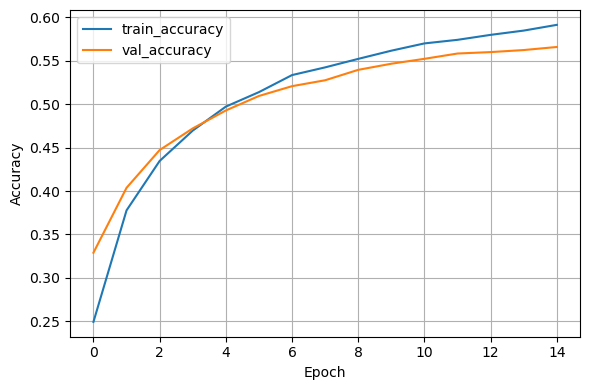

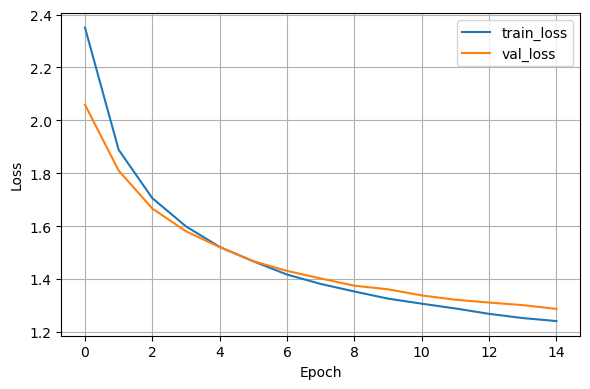

In [23]:
def plot_history(history, metric="accuracy"):
    plt.figure(figsize=(6,4))
    plt.plot(history.history[metric], label=f"train_{metric}")
    plt.plot(history.history[f"val_{metric}"], label=f"val_{metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_history(history_vit_pre, metric="accuracy")
plot_history(history_vit_pre, metric="loss")

2025-12-09 13:39:45.693452: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification report (ViT):
                  precision    recall  f1-score   support

    Academic_Art       0.65      0.33      0.44       137
     Art_Nouveau       0.63      0.62      0.62       304
         Baroque       0.56      0.44      0.49       535
   Expressionism       0.56      0.77      0.65       273
    Japanese_Art       0.83      0.69      0.76       226
   Neoclassicism       0.69      0.44      0.54       324
     Primitivism       0.64      0.54      0.59       124
         Realism       0.64      0.56      0.60       552
     Renaissance       0.52      0.77      0.62       593
          Rococo       0.49      0.44      0.46       243
     Romanticism       0.49      0.60      0.54       656
       Symbolism       0.25      0.14      0.18       146
Western_Medieval       0.81      0.80      0.81       111

        accuracy                           0.57      4224
       macro avg       0.60      0.55      0.56      4224
    weighted avg       0.58      0.57    

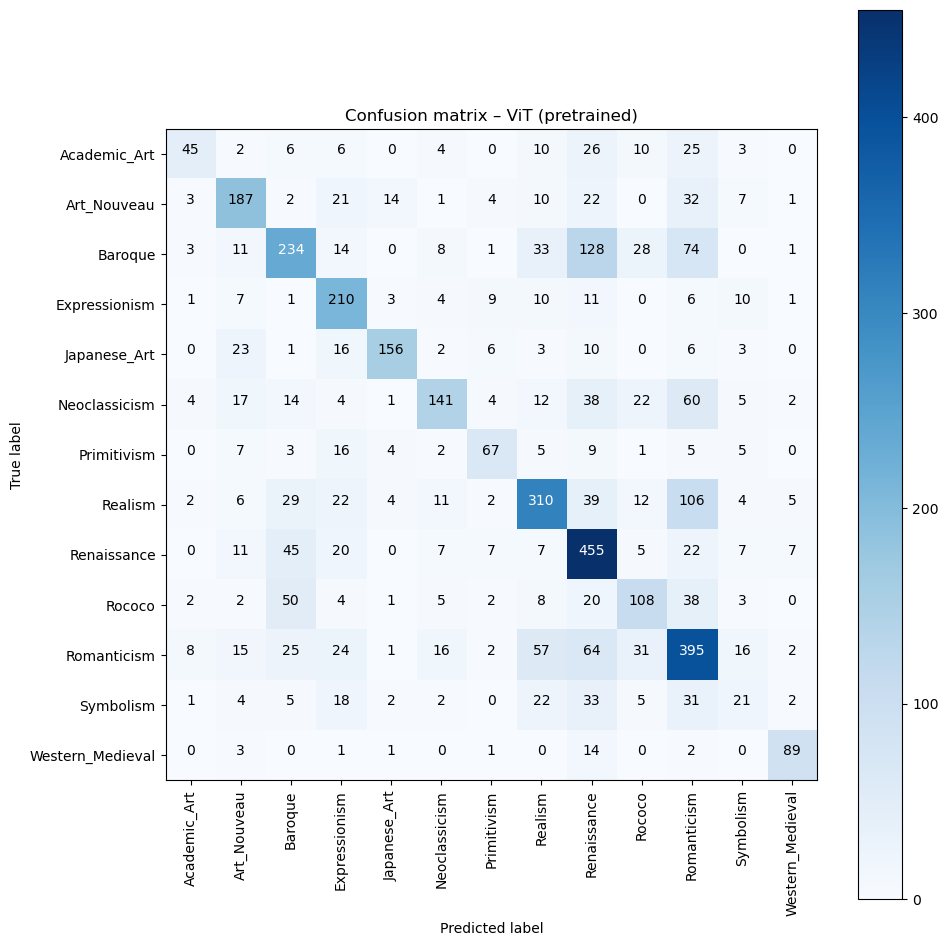

In [17]:
# Get predictions
y_true = []
y_pred = []

for batch_images, batch_labels in test_ds_prep:
    preds = vit_pre_model.predict(batch_images, verbose=0)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
print("Classification report (ViT):")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix – ViT (pretrained)")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j], "d"),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

### Observe training process of Baseline CNN

In [19]:
cnn_model = keras.models.load_model("./models/art_style_cnn")

In [72]:
cnn_test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT,
    image_size=(512, 512),       # DO NOT CHANGE
    batch_size=BATCH_SIZE,
    shuffle=False
)
# DO NOT SCALE HERE!
# CNN will do Resizing + Rescaling INSIDE the model

Found 42385 files belonging to 13 classes.


Classification report (ViT):
                  precision    recall  f1-score   support

    Academic_Art       0.92      0.80      0.86      1300
     Art_Nouveau       0.89      0.88      0.88      3031
         Baroque       0.85      0.88      0.86      5295
   Expressionism       0.86      0.83      0.84      2606
    Japanese_Art       0.91      0.90      0.90      2231
   Neoclassicism       0.94      0.88      0.91      3110
     Primitivism       0.88      0.86      0.87      1300
         Realism       0.85      0.87      0.86      5353
     Renaissance       0.86      0.89      0.88      6183
          Rococo       0.85      0.88      0.86      2519
     Romanticism       0.86      0.89      0.88      6789
       Symbolism       0.92      0.79      0.85      1510
Western_Medieval       0.95      0.82      0.88      1158

        accuracy                           0.87     42385
       macro avg       0.89      0.86      0.87     42385
    weighted avg       0.87      0.87    

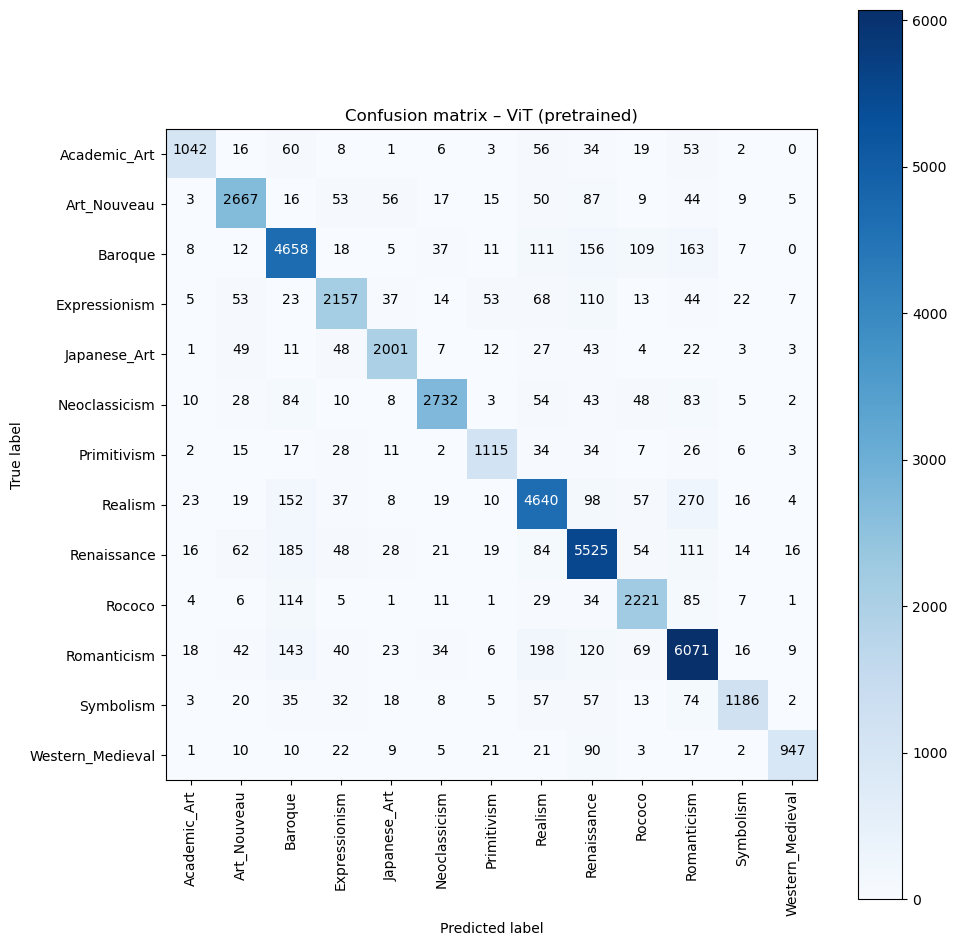

In [53]:
# Get predictions
y_true = []
y_pred = []

for batch_images, batch_labels in cnn_test_ds:
    preds = cnn_model.predict(batch_images, verbose=0)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
print("Classification report (Baseline CNN):")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix – Baseline CNN")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j], "d"),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

### Observe training process of Transfer Learning

In [33]:
tl_model = keras.models.load_model("./models/art_style_inceptionV3.keras")

In [51]:
# tl_test_ds = tf.keras.utils.image_dataset_from_directory(
#     DATA_ROOT,
#     image_size=(512, 512), 
#     batch_size=BATCH_SIZE,
#     shuffle=False
# )

tl_val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=BATCH_SIZE
)

# Split val into val + test
tl_val_batches = tf.data.experimental.cardinality(tl_val_ds)
tl_test_ds = tl_val_ds.take(tl_val_batches // 2)
tl_val_ds  = tl_val_ds.skip(tl_val_batches // 2)

Found 42385 files belonging to 13 classes.
Using 12715 files for validation.


In [39]:
tl_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,069,641 (202.44 MB)

 Trainable params: 15,353,869 (58.57 MB)

 Non-trainable params: 7,008,032 (26.73 MB)

 Optimizer params: 30,707,740 (117.14 MB)

In [61]:
for layer in tl_model.get_layer("inception_v3").layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(layer.name)

conv2d_188
conv2d_189
conv2d_190
conv2d_191
conv2d_192
conv2d_196
conv2d_194
conv2d_197
conv2d_193
conv2d_195
conv2d_198
conv2d_199
conv2d_203
conv2d_201
conv2d_204
conv2d_200
conv2d_202
conv2d_205
conv2d_206
conv2d_210
conv2d_208
conv2d_211
conv2d_207
conv2d_209
conv2d_212
conv2d_213
conv2d_215
conv2d_216
conv2d_214
conv2d_217
conv2d_222
conv2d_223
conv2d_219
conv2d_224
conv2d_220
conv2d_225
conv2d_218
conv2d_221
conv2d_226
conv2d_227
conv2d_232
conv2d_233
conv2d_229
conv2d_234
conv2d_230
conv2d_235
conv2d_228
conv2d_231
conv2d_236
conv2d_237
conv2d_242
conv2d_243
conv2d_239
conv2d_244
conv2d_240
conv2d_245
conv2d_238
conv2d_241
conv2d_246
conv2d_247
conv2d_252
conv2d_253
conv2d_249
conv2d_254
conv2d_250
conv2d_255
conv2d_248
conv2d_251
conv2d_256
conv2d_257
conv2d_260
conv2d_261
conv2d_258
conv2d_262
conv2d_259
conv2d_263
conv2d_268
conv2d_265
conv2d_269
conv2d_266
conv2d_267
conv2d_270
conv2d_271
conv2d_264
conv2d_272
conv2d_277
conv2d_274
conv2d_278
conv2d_275
conv2d_276
conv2d_279

Classification report (TL using InceptionV3):
                  precision    recall  f1-score   support

    Academic_Art       0.95      0.89      0.92       192
     Art_Nouveau       0.95      0.95      0.95       475
         Baroque       0.94      0.95      0.94       798
   Expressionism       0.96      0.95      0.96       377
    Japanese_Art       0.92      0.97      0.95       349
   Neoclassicism       0.97      0.91      0.94       474
     Primitivism       0.96      0.96      0.96       208
         Realism       0.97      0.87      0.92       797
     Renaissance       0.94      0.96      0.95       943
          Rococo       0.89      0.91      0.90       363
     Romanticism       0.89      0.95      0.92      1010
       Symbolism       0.88      0.90      0.89       225
Western_Medieval       0.98      0.98      0.98       157

        accuracy                           0.93      6368
       macro avg       0.94      0.93      0.94      6368
    weighted avg       0

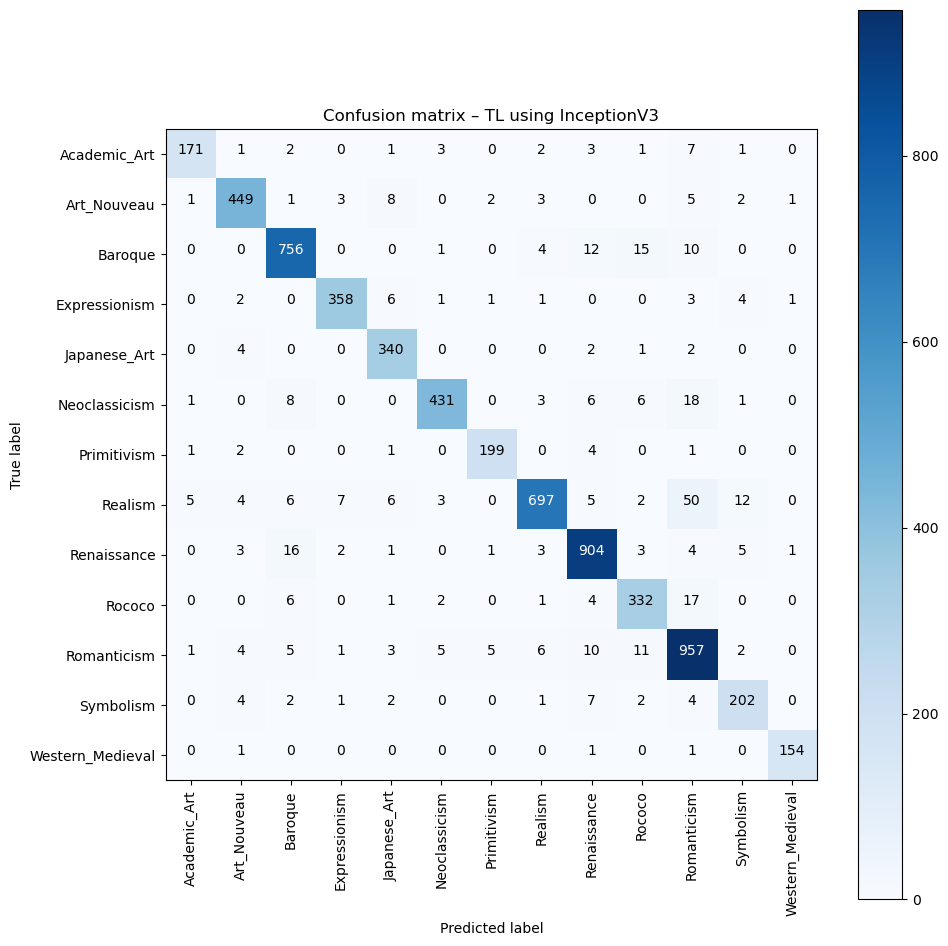

In [59]:
# Get predictions
y_true = []
y_pred = []

for batch_images, batch_labels in tl_test_ds:
    preds = tl_model.predict(batch_images, verbose=0)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
print("Classification report (TL using InceptionV3):")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix – TL using InceptionV3")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j], "d"),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

## Build Grad-CAM Helpers

### For Baseline CNN

In [171]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    img_array: shape (1, H, W, 3)
    model: trained Sequential keras model
    last_conv_layer_name: name of last conv layer (e.g., "conv2d_8")
    pred_index: optional class index; if None, uses top predicted class
    """

    # Make sure we’re working with a tf.Tensor the tape can track
    img_tensor = tf.convert_to_tensor(img_array)

    with tf.GradientTape() as tape:
        x = img_tensor
        conv_outputs = None

        # Manually forward through the Sequential model
        for layer in model.layers:
            x = layer(x)
            if layer.name == last_conv_layer_name:
                conv_outputs = x
                

        # x is now the final logits / predictions
        predictions = x

        if pred_index is None:
            pred_index = tf.argmax(predictions[0])

        class_channel = predictions[:, pred_index]

        # Tell the tape we care about conv_outputs
        tape.watch(conv_outputs)

        # Compute gradient of target class w.r.t conv feature map
        grads = tape.gradient(class_channel, conv_outputs)

    # Global-average-pool gradients over spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # (C,)

    # Weight conv feature maps by “importance”
    conv_outputs = conv_outputs[0]                         # (H', W', C)
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis] # (H', W', 1)
    heatmap = tf.squeeze(heatmap)                          # (H', W')

    # ReLU & normalize to [0,1]
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= (tf.reduce_max(heatmap) + 1e-8)

    return heatmap.numpy()

In [173]:
def overlay_gradcam_on_image(img, heatmap, alpha=0.4):
    """
    img: (H, W, 3) RGB image, scaled [0,1]
    heatmap: (H', W') float [0,1], will be resized to image size
    """
    import cv2  # if you prefer to avoid cv2, you can use PIL + numpy; keeping cv2 for convenience

    h, w = img.shape[:2]
    heatmap_resized = cv2.resize(heatmap, (w, h))

    heatmap_color = plt.cm.jet(heatmap_resized)[..., :3]  # drop alpha

    superimposed_img = (1 - alpha) * img + alpha * heatmap_color
    superimposed_img = np.clip(superimposed_img, 0, 1)
    return superimposed_img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted class index: 4, p=0.765


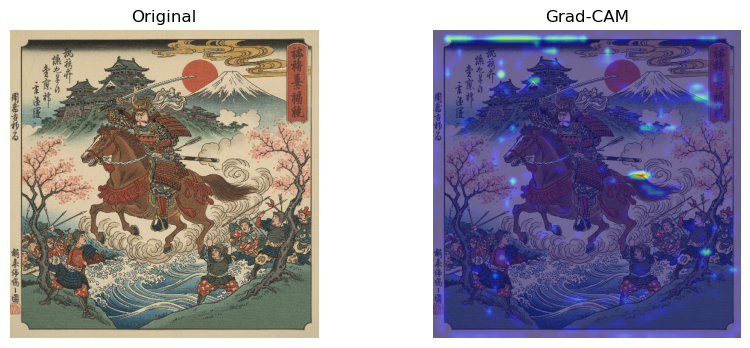

In [183]:
LAST_CONV_LAYER_NAME = "conv2d_8"
# LAST_CONV_LAYER_NAME = "inception_v3"

def run_gradcam_example(img_path, model, last_conv_layer_name):
    # Load image in the same way the CNN expects (512x512, it has internal Resizing+Rescaling)
    img = tf.keras.utils.load_img(img_path, target_size=(512, 512))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # (1, 512, 512, 3)

    # Get prediction
    preds = model.predict(img_array)
    pred_class = np.argmax(preds[0])
    pred_proba = preds[0][pred_class]
    print(f"Predicted class index: {pred_class}, p={pred_proba:.3f}")

    # Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(
        img_array,
        model=model,
        last_conv_layer_name=last_conv_layer_name,
        pred_index=pred_class,
    )

    # For display, normalize image to [0,1]
    img_norm = img_array[0] / 255.0
    overlay = overlay_gradcam_on_image(img_norm, heatmap, alpha=0.5)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(img_norm)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

# Example call
run_gradcam_example("./JA3.png", cnn_model, LAST_CONV_LAYER_NAME)
# run_gradcam_example("./ArtNouveau1.png", tl_model, LAST_CONV_LAYER_NAME)

### For Transfer Learning using InceptionV3

In [185]:
backbone_layer = tl_model.get_layer("inception_v3")

# Submodel: input -> output of inception_v3 (includes true_divide_2, subtract_2)
backbone_model = keras.Model(
    inputs=tl_model.input,
    outputs=backbone_layer.output,   # (None, 5, 5, 2048)
)

In [187]:
def make_gradcam_heatmap_tl(img_array, class_index=None):
    """
    Grad-CAM for the existing transfer-learning model.

    img_array: (1, 224, 224, 3) float32 in [0, 255]
    class_index: optional target class; if None we compute it from the head.
    """

    # --- 1. Get backbone feature maps OUTSIDE the tape ---
    # This runs the full preprocessing + inception_v3 just like tl_model.
    conv_out = backbone_model.predict(img_array, verbose=0)   # (1, 5, 5, 2048)

    feature_maps = tf.convert_to_tensor(conv_out)             # (1, H, W, C)

    # --- 2. Run ONLY the classification head inside GradientTape ---
    with tf.GradientTape() as tape:
        tape.watch(feature_maps)

        x = feature_maps
        for name in HEAD_LAYER_NAMES:
            layer = tl_model.get_layer(name)
            # Important: training=False so dropout is disabled
            x = layer(x, training=False)

        preds_head = x                                        # (1, num_classes)

        # If class not given, use top prediction from the head
        if class_index is None:
            class_index = tf.argmax(preds_head[0])
        class_score = preds_head[:, class_index]

    # --- 3. Gradients of class score wrt feature maps ---
    grads = tape.gradient(class_score, feature_maps)          # (1, H, W, C)

    # --- 4. Global-average-pool gradients over spatial dims ---
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))      # (C,)

    # --- 5. Weight channels by importance + sum ---
    conv_outputs = feature_maps[0]                            # (H, W, C)
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)  # (H, W)

    # --- 6. ReLU + normalize to [0,1] ---
    heatmap = tf.maximum(heatmap, 0.0)
    max_val = tf.reduce_max(heatmap)
    heatmap = heatmap / (max_val + 1e-8)

    return heatmap.numpy()

In [189]:
def load_image_for_tl(path, target_size=(224, 224)):
    """Load image in the resolution tl_model expects, keep [0,255]."""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.cast(img, tf.float32)           # [0,255]
    img_array = tf.expand_dims(img, axis=0)  # (1, H, W, 3)
    return img_array


def overlay_gradcam(img_array, heatmap, alpha=0.4):
    """Overlay Grad-CAM heatmap on the original image."""
    img_disp = img_array[0].numpy() / 255.0
    h, w, _ = img_disp.shape

    # Resize heatmap to image size
    heatmap_resized = cv2.resize(heatmap, (w, h))

    # Colorize heatmap
    heatmap_color = cv2.applyColorMap(
        np.uint8(255 * heatmap_resized),
        cv2.COLORMAP_JET
    )
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB) / 255.0

    # Blend
    superimposed = alpha * heatmap_color + (1 - alpha) * img_disp
    superimposed = np.clip(superimposed, 0, 1)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_disp)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.title("Grad-CAM – TL InceptionV3")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [191]:
def run_gradcam_example(img_path):
    # Load image
    img_array = load_image_for_tl(img_path)

    # Get prediction from your original tl_model (for reporting)
    preds = tl_model.predict(img_array, verbose=0)
    pred_class = int(np.argmax(preds[0]))
    pred_proba = float(np.max(preds[0]))
    print(f"[tl_model] predicted class index: {pred_class}, prob={pred_proba:.3f}")

    # Build Grad-CAM heatmap using backbone + head
    heatmap = make_gradcam_heatmap_tl(img_array, class_index=pred_class)

    # Show overlay
    overlay_gradcam(img_array, heatmap)

In [193]:
run_gradcam_example("./ArtNouveau1.png")

[tl_model] predicted class index: 12, prob=0.921


KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m14892563488\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 224, 224, 3), dtype=float32)\n  • training=False\n  • mask=None\n  • kwargs=<class 'inspect._empty'>"

In [137]:
print(tl_model.input.shape)
print(feature_extractor.output.shape)

(None, 224, 224, 3)
(None, 5, 5, 2048)


## Evaluation Framework

In [35]:
# Load trained models from disk

# Baseline CNN
cnn_model = keras.models.load_model("./models/art_style_cnn")

# # Transfer learning MobileNet (or your TL CNN)
tl_model = keras.models.load_model("./models/art_style_inceptionV3.keras")

# Vision Transformer (head-trained)
vit_model = keras.models.load_model("./models/art_style_vit.keras")

/Applications/anaconda3/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:749: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/Applications/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def collect_misclassified_examples(
    model,
    test_ds,
    class_names,
    target_class,
    max_examples=16,
    mode="true",   # "true" -> true class = target, "pred" -> predicted class = target
):
    """
    Collect misclassified examples for a given class and model.

    Args:
        model: Trained Keras model (CNN, MobileNet, ViT, etc.).
        test_ds: Dataset yielding (images, int_labels).
        class_names: List of class names in index order.
        target_class: Either class index (int) or class name (str).
        max_examples: Maximum number of misclassified examples to return.
        mode:
            - "true": examples where true label == target, but prediction != target (false negatives).
            - "pred": examples where prediction == target, but true label != target (false positives).

    Returns:
        images: np.ndarray of shape (N, H, W, 3)
        y_true: np.ndarray of shape (N,)
        y_pred: np.ndarray of shape (N,)
    """
    # Resolve target class index
    if isinstance(target_class, str):
        if target_class not in class_names:
            raise ValueError(f"Unknown class name '{target_class}'. Available: {class_names}")
        target_idx = class_names.index(target_class)
    else:
        target_idx = int(target_class)
        if target_idx < 0 or target_idx >= len(class_names):
            raise ValueError(f"target_class index {target_idx} out of range.")

    collected_images = []
    collected_true = []
    collected_pred = []

    for batch_images, batch_labels in test_ds:
        preds = model.predict(batch_images, verbose=0)
        preds_idx = np.argmax(preds, axis=1)
        true_idx = batch_labels.numpy()

        for i in range(len(true_idx)):
            t = int(true_idx[i])
            p = int(preds_idx[i])

            if mode == "true":
                # True class is target, but prediction is wrong
                if t == target_idx and p != target_idx:
                    collected_images.append(batch_images[i].numpy())
                    collected_true.append(t)
                    collected_pred.append(p)
            elif mode == "pred":
                # Predicted as target, but true class is different
                if p == target_idx and t != target_idx:
                    collected_images.append(batch_images[i].numpy())
                    collected_true.append(t)
                    collected_pred.append(p)
            else:
                raise ValueError("mode must be 'true' or 'pred'.")

            if len(collected_images) >= max_examples:
                break

        if len(collected_images) >= max_examples:
            break

    if len(collected_images) == 0:
        print(f"No misclassified examples found for class '{class_names[target_idx]}' with mode='{mode}'.")
        return np.array([]), np.array([]), np.array([])

    images = np.stack(collected_images, axis=0)
    y_true = np.array(collected_true)
    y_pred = np.array(collected_pred)

    print(
        f"Collected {len(images)} misclassified examples for class "
        f"'{class_names[target_idx]}' (mode='{mode}')."
    )

    return images, y_true, y_pred

In [ ]:
images_imp_fn, y_true_imp_fn, y_pred_imp_fn = collect_misclassified_examples(
    model=cnn_model,              # or mobilenet_model, vit_model
    test_ds=test_ds_prep,
    class_names=class_names,
    target_class="Impressionism",  # or index, e.g. 3
    max_examples=12,
    mode="true",
)

In [ ]:
images_imp_fp, y_true_imp_fp, y_pred_imp_fp = collect_misclassified_examples(
    model=cnn_model,
    test_ds=test_ds_prep,
    class_names=class_names,
    target_class="Impressionism",
    max_examples=12,
    mode="pred",
)

In [39]:
# # Helper layers
# class Patches(layers.Layer):
#     def __init__(self, patch_size, **kwargs):
#         super().__init__(**kwargs)
#         self.patch_size = patch_size

#     def call(self, images):
#         batch_size = tf.shape(images)[0]
#         patches = tf.image.extract_patches(
#             images=images,
#             sizes=[1, self.patch_size, self.patch_size, 1],
#             strides=[1, self.patch_size, self.patch_size, 1],
#             rates=[1, 1, 1, 1],
#             padding="VALID",
#         )
#         patch_dims = patches.shape[-1]
#         patches = tf.reshape(patches, [batch_size, -1, patch_dims])
#         return patches

#     def get_config(self):
#         config = super().get_config()
#         config.update({"patch_size": self.patch_size})
#         return config


# class PatchEncoder(layers.Layer):
#     def __init__(self, num_patches, projection_dim, **kwargs):
#         super().__init__(**kwargs)
#         self.num_patches = num_patches
#         self.projection = layers.Dense(units=projection_dim)
#         self.position_embedding = layers.Embedding(
#             input_dim=num_patches, output_dim=projection_dim
#         )

#     def call(self, patch):
#         positions = tf.range(start=0, limit=self.num_patches, delta=1)
#         encoded = self.projection(patch) + self.position_embedding(positions)
#         return encoded

#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             "num_patches": self.num_patches,
#             "projection_dim": self.projection.units,
#         })
#         return config


# def mlp(x, hidden_units, dropout_rate):
#     for units in hidden_units:
#         x = layers.Dense(units, activation="gelu")(x)
#         x = layers.Dropout(dropout_rate)(x)
#     return x

In [41]:
# # Build ViT classifier
# def create_vit_classifier(
#     input_shape=IMAGE_SIZE + (3,),
#     num_classes=NUM_CLASSES,
#     patch_size=16,
#     projection_dim=128,
#     transformer_layers=8,
#     num_heads=8,
#     transformer_mlp_units=[256, 128],
#     head_mlp_units=[512, 256],
# ):
#     inputs = layers.Input(shape=input_shape)

#     # Data augmentation
#     augmented = data_augmentation(inputs)

#     # Create patches.
#     patches = Patches(patch_size, name="patches")(augmented)
#     num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

#     # Encode patches.
#     encoded_patches = PatchEncoder(num_patches, projection_dim, name="patch_encoder")(patches)

#     # Create multiple layers of the Transformer block.
#     for _ in range(transformer_layers):
#         # Layer normalization 1.
#         x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
#         # Multi-head attention layer.
#         attention_output = layers.MultiHeadAttention(
#             num_heads=num_heads, key_dim=projection_dim, dropout=0.1
#         )(x1, x1)
#         # Skip connection 1.
#         x2 = layers.Add()([attention_output, encoded_patches])
#         # Layer normalization 2.
#         x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
#         # MLP.
#         x3 = mlp(x3, hidden_units=transformer_mlp_units, dropout_rate=0.1)
#         # Skip connection 2.
#         encoded_patches = layers.Add()([x3, x2])

#     # Create a [batch, projection_dim] tensor.
#     representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
#     representation = layers.GlobalAveragePooling1D()(representation)

#     representation = layers.Dropout(0.3)(representation)
#     features = mlp(representation, hidden_units=head_mlp_units, dropout_rate=0.3)

#     logits = layers.Dense(num_classes, activation="softmax", name="predictions")(features)

#     model = keras.Model(inputs=inputs, outputs=logits, name="vit_classifier")
#     return model


# vit_model = create_vit_classifier()
# vit_model.summary()

Model: "vit_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 768) │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 196, 128)  │    123,520 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 128)  │    527,488 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_34 (Add)        │ (None, 196, 128)  │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ add_34[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 196, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_58          │ (None, 196, 256)  │          0 │ dense_42[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 196, 128)  │     32,896 │ dropout_58[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_59          │ (None, 196, 128)  │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_35 (Add)        │ (None, 196, 128)  │          0 │ dropout_59[0][0], │
│                     │                   │            │ add_34[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ add_35[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 128)  │    527,488 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 196, 128)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_35[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ add_36[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 196, 256)  │     33,024 │ layer_normalizat

 Total params: 5,075,853 (19.36 MB)

 Trainable params: 5,075,853 (19.36 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# # Train
# history = vit_model.fit(
#     train_ds_prep,
#     validation_data=val_ds_prep,
#     epochs=EPOCHS,
#     callbacks=callbacks,
#     class_weight=class_weight,
# )

Epoch 1/15
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1526s 1s/step - accuracy: 0.1858 - loss: 2.3354 - val_accuracy: 0.2276 - val_loss: 2.2187 - learning_rate: 3.0000e-04
Epoch 2/15
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1527s 1s/step - accuracy: 0.2369 - loss: 2.2057 - val_accuracy: 0.2732 - val_loss: 2.1257 - learning_rate: 3.0000e-04
Epoch 3/15
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1545s 1s/step - accuracy: 0.2672 - loss: 2.1358 - val_accuracy: 0.2894 - val_loss: 2.0750 - learning_rate: 3.0000e-04
Epoch 4/15
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1532s 1s/step - accuracy: 0.2906 - loss: 2.0810 - val_accuracy: 0.2988 - val_loss: 2.0294 - learning_rate: 3.0000e-04
Epoch 5/15
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1534s 1s/step - accuracy: 0.3060 - loss: 2.0382 - val_accuracy: 0.3348 - val_loss: 1.9660 - learning_rate: 3.0000e-04
Epoch 6/15
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1529s 1s/step - accuracy: 0.3231 - loss: 2.0006 - val_accuracy: 0.3374 - val_loss: 1.9509 - learning_rate: 3.0000e-04
Epoch 7/15
1060/1060 ━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 